In [ ]:
%pip install transformers datasets --quiet

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-imageability')

In [3]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [4]:

from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords

sw = set(stopwords.words('english'))

def tokenize(text, menmonic_words = set()):
    text = re.sub('<.*?>', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [w for w in tokens if not w in sw and not w in menmonic_words]
    filtered_tokens = [w for w in filtered_tokens if w.isalpha()]

    return filtered_tokens

In [8]:

sample = ds['train'][0]
sample

{'kanji_id': 1885,
 'component_meanings': 'woman,catapult',
 'wanikani_mnemonic': "A <radical>woman</radical> loves her <radical>catapult</radical> for some good ol' fashioned <kanji>recreation</kanji>. You ask the woman what she does for fun... for recreation. She says, she goes out and shoots her catapult.",
 'kanji_meaning': 'recreation',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form, recreation of woman being catapulted to her death has been edited out.)\n\n\nAMY GOODMAN: We begin today's show with the shocking news that two women have died after jumping from an overpass near Los Angeles International Airport and landing on I-5 southbound just before",
 'gpt3_paragraph': 'A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the moment and the satisfaction of her successful shots.',
 'gpt3_mnemonic': "Once upon a time there was

In [9]:

tokenize(sample['wanikani_mnemonic'], set(sample['component_meanings'].split(',') + [sample['kanji_meaning']]))

['A',
 'loves',
 'good',
 'ol',
 'fashioned',
 'You',
 'ask',
 'fun',
 'She',
 'says',
 'goes',
 'shoots']

In [14]:
from scipy.stats import f_oneway
def anova(ds):
    f, p = f_oneway(ds['gpt3_paragraph_img_mean'], ds['gpt3_mnemonic_img_mean'], ds['gpt3_mnemonic_img_mean'], ds['wanikani_img_mean'], ds['gpt2xl_img_mean'])
    return p

In [15]:
import matplotlib.pyplot as plt

def box_plot(df, title):
    fig, ax = plt.subplots(1,1)
    ax.boxplot([df['gpt3_paragraph_img_mean'], df['gpt3_mnemonic_img_mean'], df['wanikani_img_mean'], df['gpt2xl_img_mean']])
    ax.set_xticklabels(['GPT-3 Paragraph', 'GPT-3 Mnemonic', 'WaniKani', 'GPT-2XL'])
    ax.set_title(title)
    plt.show()

In [16]:
def predict(word):
    inputs = tokenizer(word, return_tensors="pt", truncation=True, padding='max_length', max_length=10).to(device)
    outputs = model(**inputs)
    return outputs.logits.item()

In [17]:
def img_sorted_scores(text, mnemonic_words=set()):
    tokens = tokenize(text, mnemonic_words)
    scores = [predict(token) for token in tokens]
    return sorted(scores, reverse=True)

def map_img_scores(bar=None):
    def func(example):
        mnemonic_words = set(example['component_meanings'].split(',') + [example['kanji_meaning']])
        example['gpt3_paragraph_img'] = img_sorted_scores(example['gpt3_paragraph'], mnemonic_words)
        example['gpt3_mnemonic_img'] = img_sorted_scores(example['gpt3_mnemonic'], mnemonic_words)
        example['wanikani_img'] = img_sorted_scores(example['wanikani_mnemonic'], mnemonic_words)
        example['gpt2xl_img'] = img_sorted_scores(example['gpt2xl_mnemonic'], mnemonic_words)

        if bar is not None:
            bar.update(1)
        return example
    return func

In [22]:
from tqdm.auto import tqdm

bar = tqdm(total=len(ds['train']))
ds_scores = ds.map(map_img_scores(bar))

  0%|          | 0/190 [00:00<?, ?it/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [23]:
import numpy as np

def prop_mean(scores, prop=1.0):
    n = int(prop * len(scores))
    if n == 0:
        n = 1

    return np.mean(scores[:n])

def map_prop_mean_score(prop=1.0):
    def func(example):
        example['gpt3_paragraph_img_mean'] = prop_mean(example['gpt3_paragraph_img'], prop)
        example['gpt3_mnemonic_img_mean'] = prop_mean(example['gpt3_mnemonic_img'], prop)
        example['wanikani_img_mean'] = prop_mean(example['wanikani_img'], prop)
        example['gpt2xl_img_mean'] = prop_mean(example['gpt2xl_img'], prop)

        return example
    return func

In [24]:
ds_mean = ds_scores.map(map_prop_mean_score(1.0))

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [25]:
p = anova(ds_mean['train'])

print(p)

0.0008158030040314012


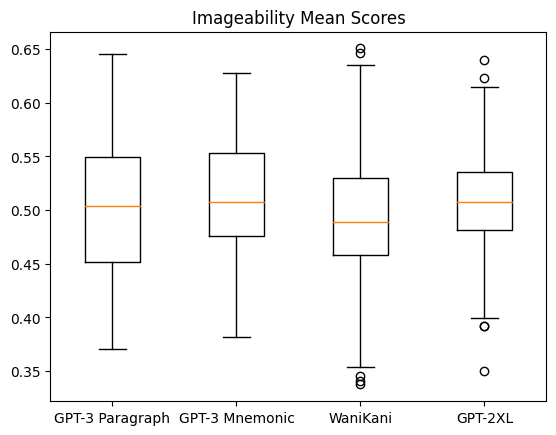

In [26]:
box_plot(ds_mean['train'], 'Imageability Mean Scores')

In [27]:
ds_mean_20 = ds_scores.map(map_prop_mean_score(0.2))

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [28]:
p = anova(ds_mean_20['train'])

print(p)

0.0018025044843039979


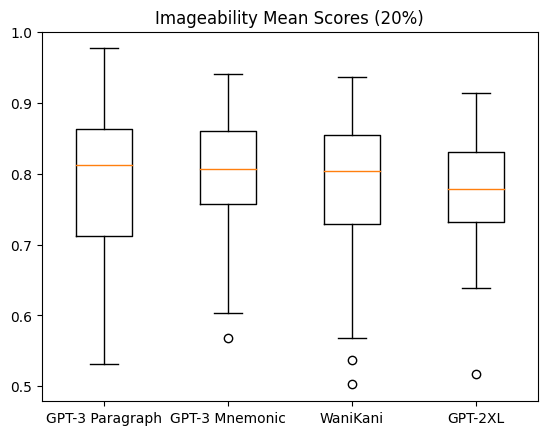

In [29]:
box_plot(ds_mean_20['train'], 'Imageability Mean Scores (20%)')